# Experimenting with Facebook Detectron2 model for Medical Image segmentation


# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15730, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 15730 (delta 206), reused 299 (delta 113), pack-reused 15277
Receiving objects: 100% (15730/15730), 6.51 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (11321/11321), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:0

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# The Brain_Segmentation Model

In [7]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid","test"]:
    register_coco_instances(f"brain_tumor_{d}", {},
                            f"/content/Brain_data/{d}/_annotations.coco.json",
                            f"/content/Brain_data/{d}")

In [10]:
import random
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

my_dataset_train_metadata = MetadataCatalog.get("brain_tumor_train")
train_dataset_dicts = DatasetCatalog.get("brain_tumor_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]

    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()

        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [06/15 08:42:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 08:42:49 d2.data.datasets.coco]: Loaded 1502 images in COCO format from /content/Brain_data/train/_annotations.coco.json


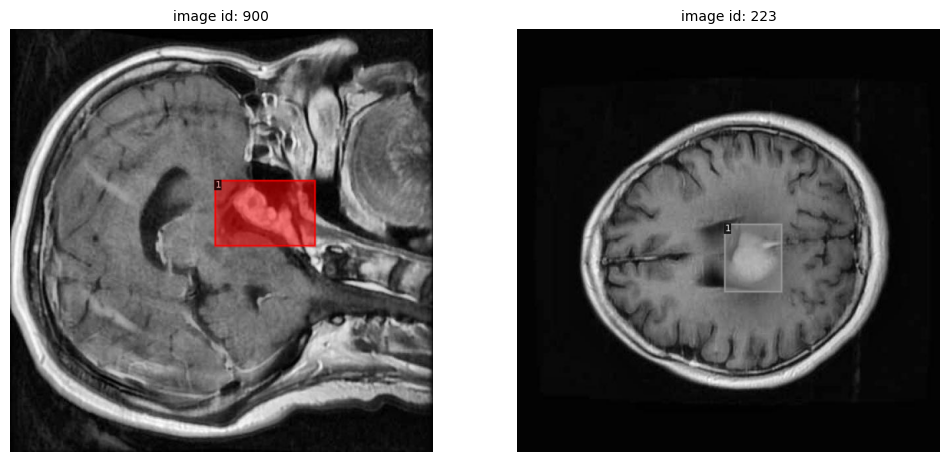

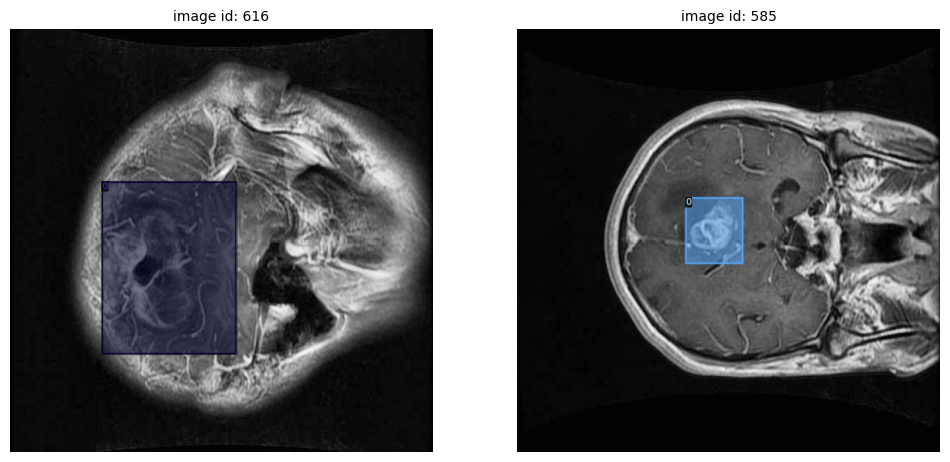

In [11]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 95, image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 99, image_scale = 1)

# **Training**

In [12]:
from detectron2.engine import DefaultTrainer

EPOCHS = 3300
NUM_CLASSES = 3
BASE_LR = 0.0001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("brain_tumor_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/15 08:45:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:04, 95.5MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/15 08:45:20 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/15 08:45:46 d2.utils.events]:  eta: 0:59:32  iter: 19  total_loss: 2.248  loss_cls: 1.387  loss_box_reg: 0.06345  loss_mask: 0.6916  loss_rpn_cls: 0.08816  loss_rpn_loc: 0.005654    time: 1.0419  last_time: 1.0630  data_time: 0.0197  last_data_time: 0.0226   lr: 1.9981e-06  max_mem: 3952M
[06/15 08:46:12 d2.utils.events]:  eta: 0:59:59  iter: 39  total_loss: 2.179  loss_cls: 1.317  loss_box_reg: 0.07247  loss_mask: 0.6906  loss_rpn_cls: 0.06354  loss_rpn_loc: 0.007203    time: 1.0592  last_time: 1.0999  data_time: 0.0106  last_data_time: 0.0054   lr: 3.9961e-06  max_mem: 3952M
[06/15 08:46:35 d2.utils.events]:  eta: 1:00:00  iter: 59  total_loss: 1.994  loss_cls: 1.154  loss_box_reg: 0.06171  loss_mask: 0.6864  loss_rpn_cls: 0.07032  loss_rpn_loc: 0.00812    time: 1.0926  last_time: 0.9953  data_time: 0.0105  last_data_time: 0.0153   lr: 5.9941e-06  max_mem: 3952M
[06/15 08:46:59 d2.utils.events]:  eta: 1:00:16  iter: 79  total_loss: 1.767  loss_cls: 0.934  loss_box_reg: 0.08268  l

In [14]:
# Saving the model
THRESHOLD = 0.6

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[06/15 09:56:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


# Training Results

In [15]:
def reading_metrics_from_json(metrics_path):
    metrics = []
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass
    return metric

In [16]:
train_metrics = reading_metrics_from_json('/content/output/metrics.json')

iters = metric(train_metrics, 'iteration')
total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
loss_mask = metric(train_metrics, 'loss_mask')
loss_box_reg = metric(train_metrics, 'loss_box_reg')


# checking metric lengths
if len(iters) == len(total_loss) == len(cls_acc) == len(loss_mask) == len(loss_box_reg):
    pass
else:
    iters = iters[:-1]

Text(0.5, 1.0, 'Mask Loss')

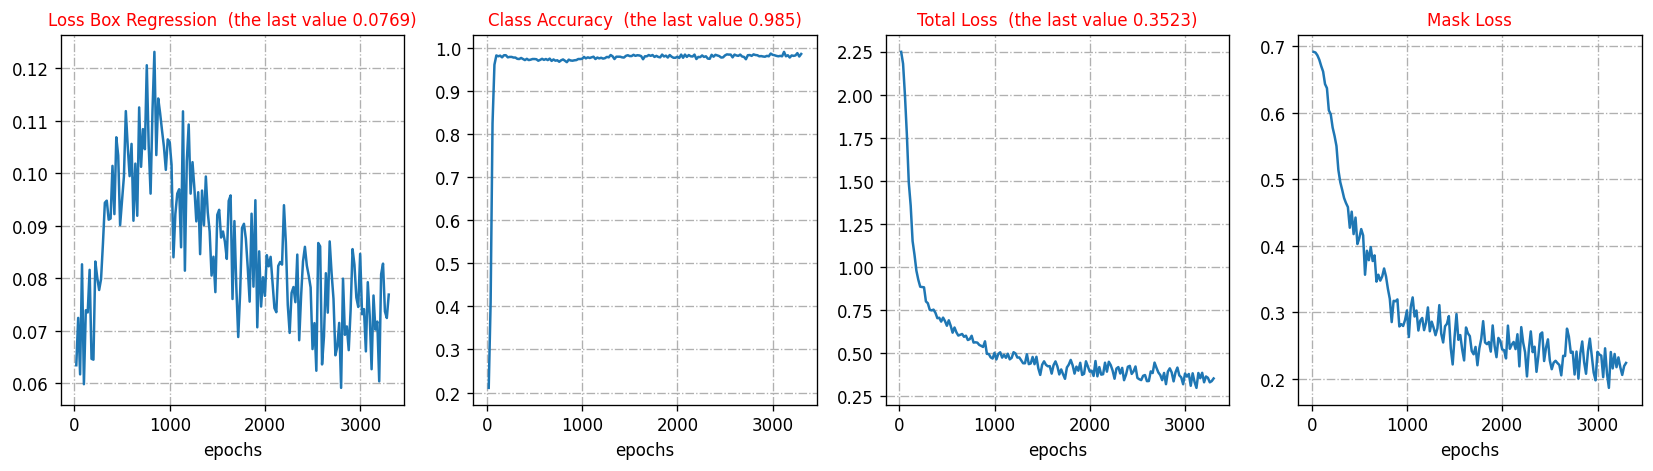

In [17]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)


axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, loss_mask)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('Mask Loss', fontsize = 10, color = 'red')

# Testing the Model

In [18]:
my_dataset_test_metadata = MetadataCatalog.get("brain_tumor_valid")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("brain_tumor_valid")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (20,20), dpi = 120)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img[:, :, ::-1], metadata= dataset_metadata, scale=image_scale, instance_mode=ColorMode.IMAGE_BW)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 20)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 20, color = 'red')
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox[:, :, ::-1])

    fig.tight_layout()

WARNING [06/15 10:04:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 10:04:09 d2.data.datasets.coco]: Loaded 429 images in COCO format from /content/Brain_data/valid/_annotations.coco.json


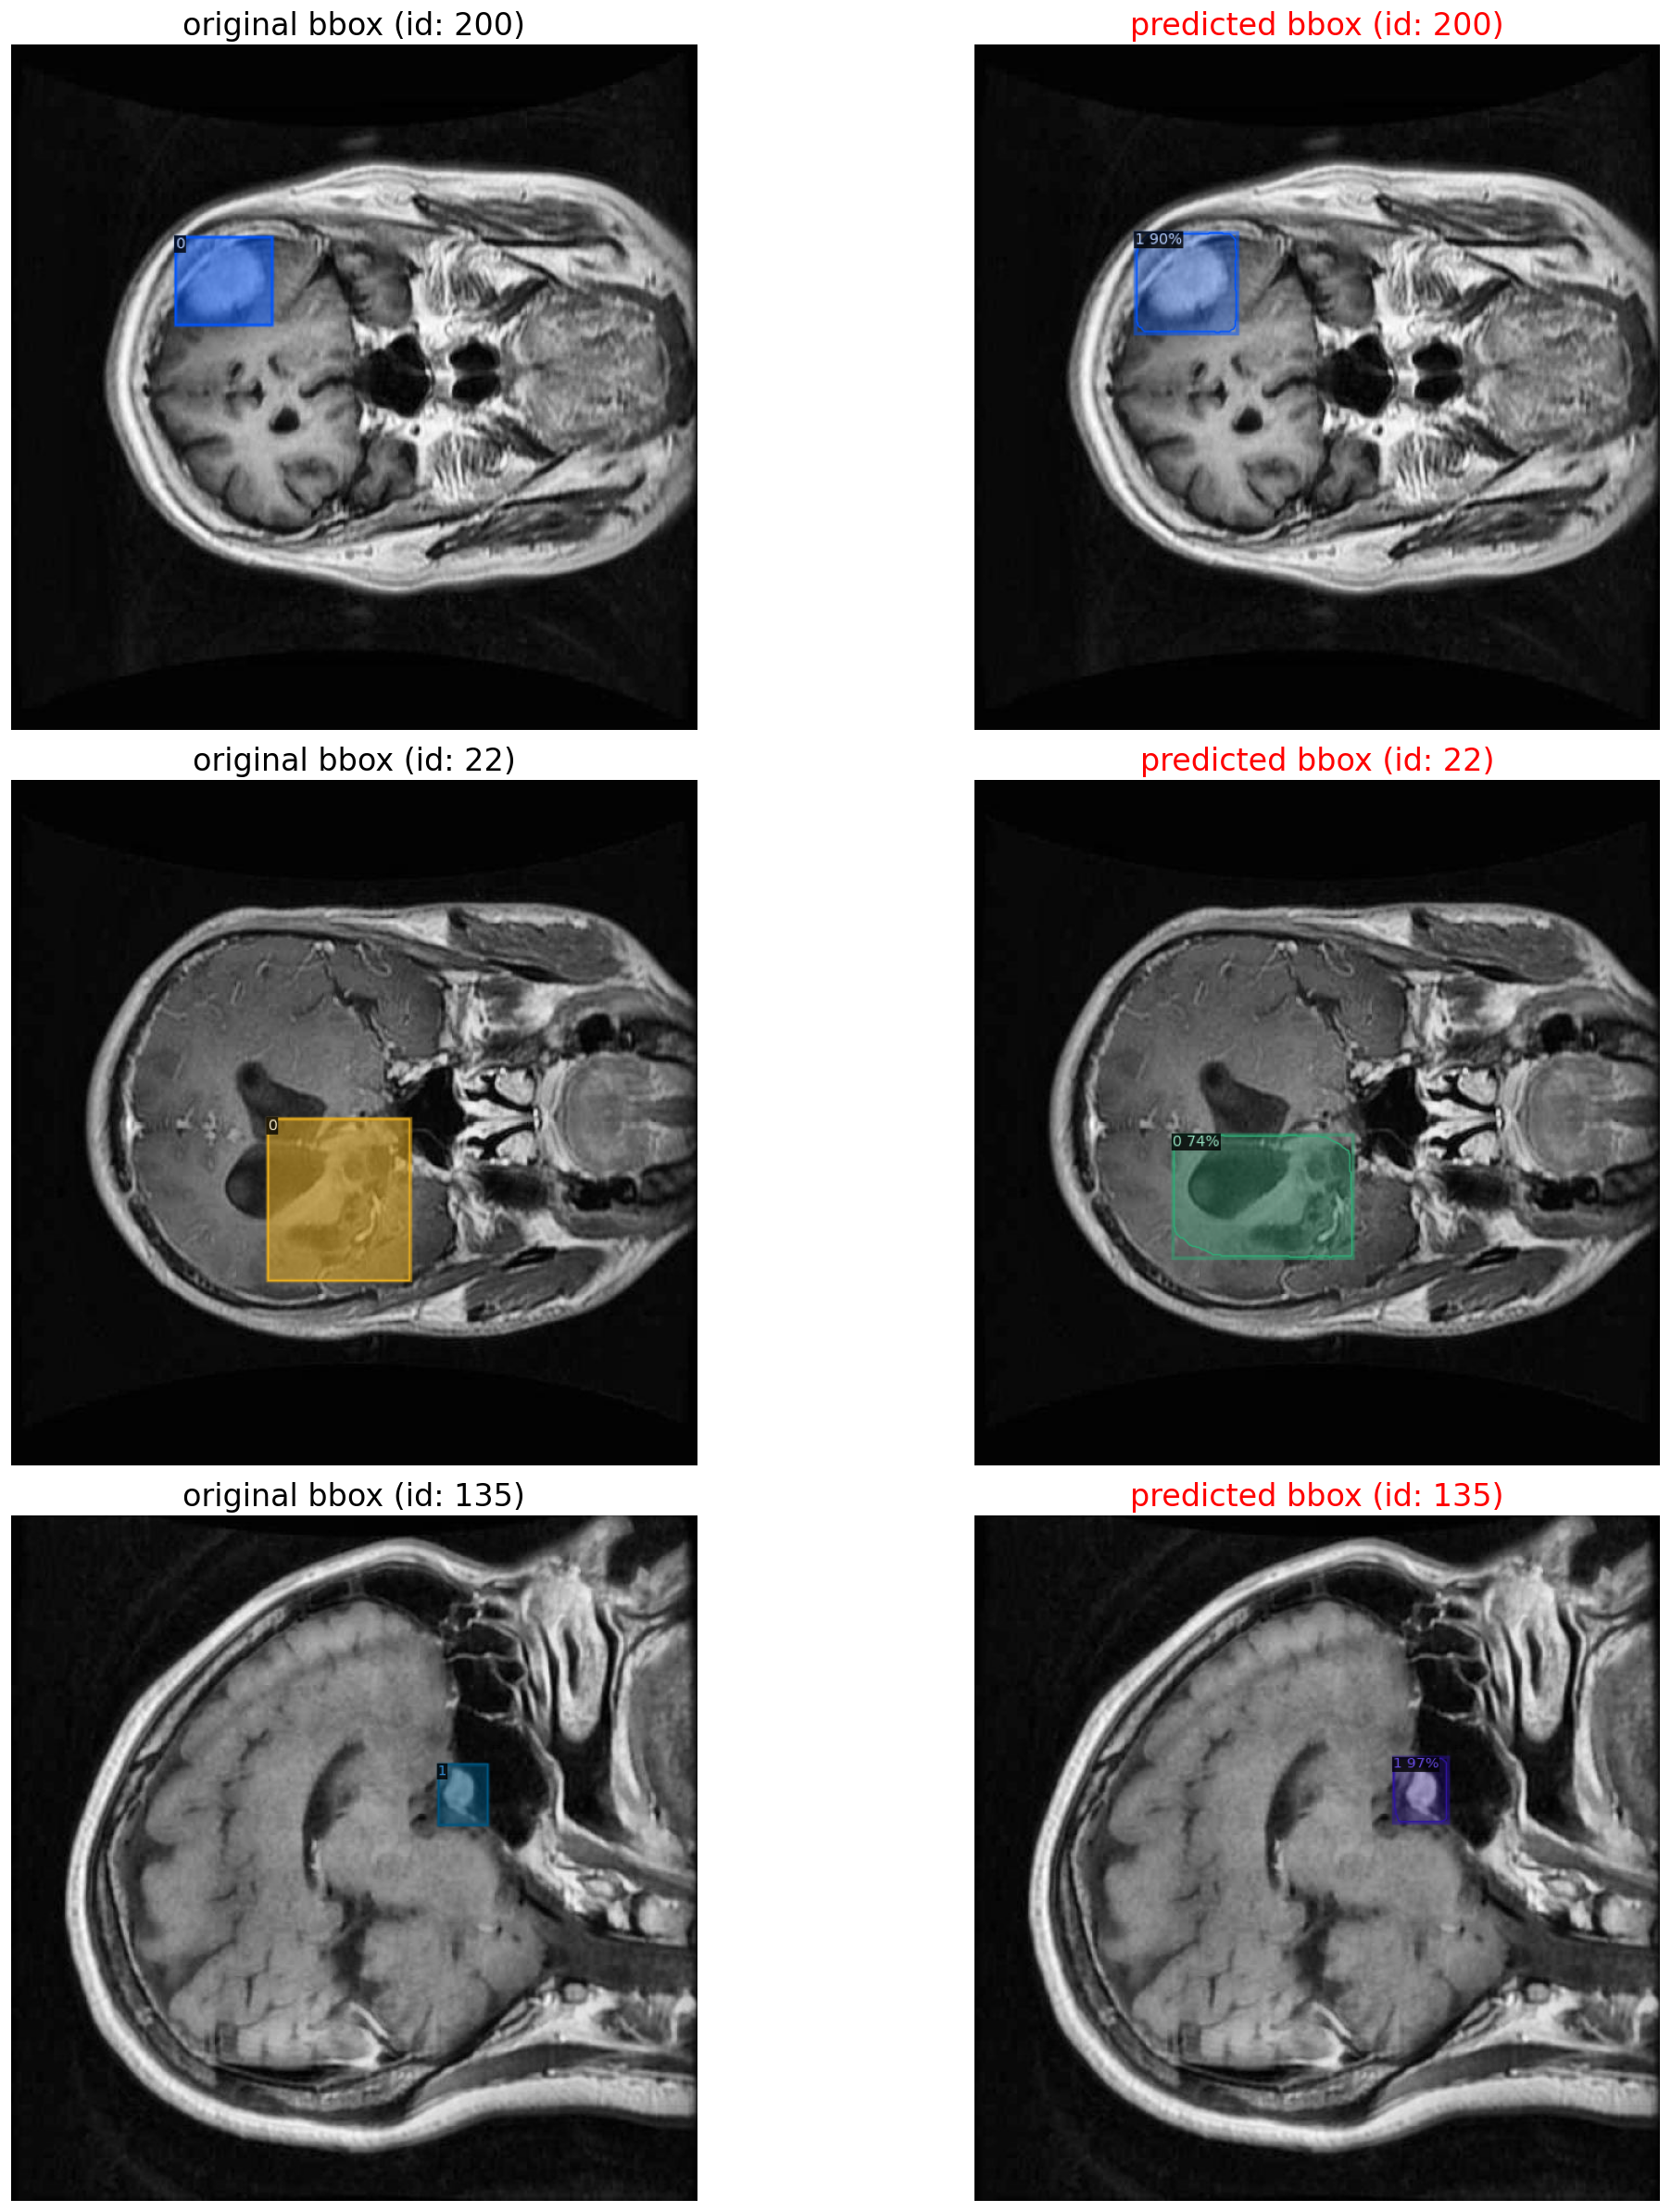

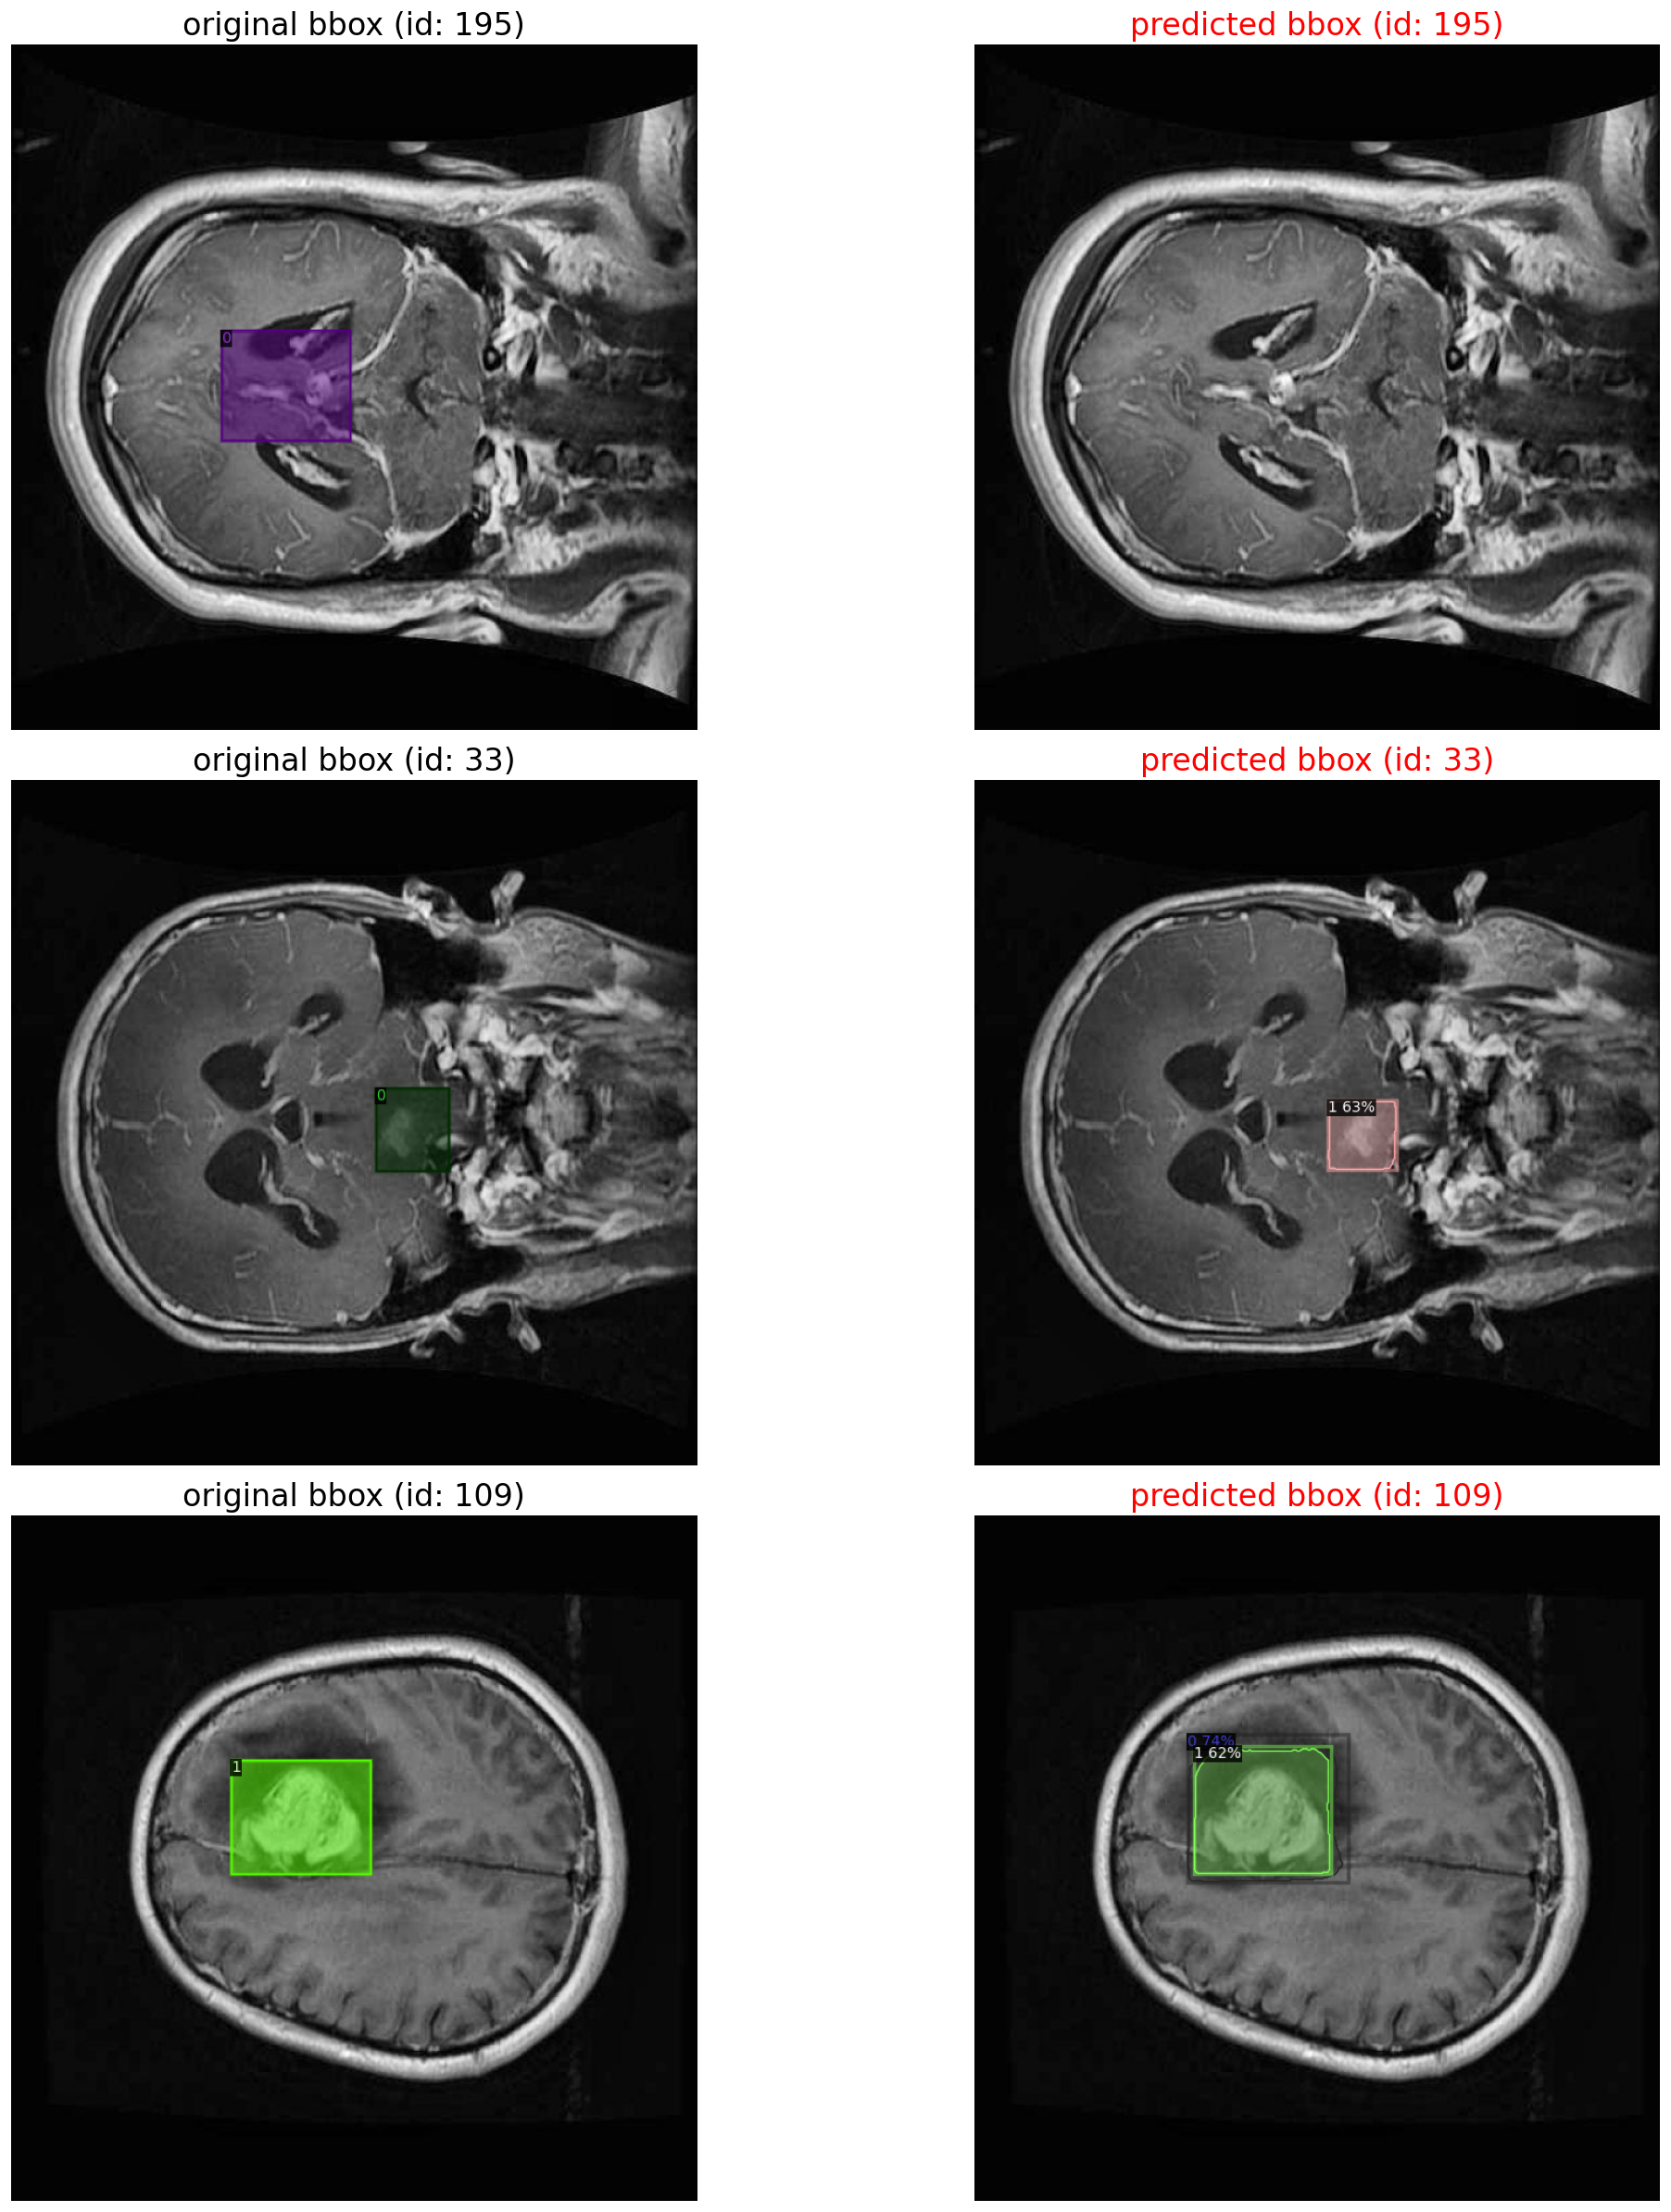

In [19]:
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 421, image_scale = 1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 83, image_scale = 1)